In [242]:
# 3rd party
import sympy as sp
import numpy as np
from IPython.utils.io import capture_output
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# Our stuff
import mainframe as mf
import nuclei_func as nf
from mainframe import Region

In [243]:
################################################################################
# INPUT DATA
################################################################################
micro_abs_water = 0.66
micro_abs_U238 = 2.73
micro_abs_U235 = 678
micro_fiss_U235 = 577

density_water = 1
density_U235 = 19.1

# Defining the temperature correction factor
def T_correction(T_new):
    return np.sqrt(293/(T_new+273))

# Defining the enrichment as a symbol
qual = 1.41516177519707e-5 #From exercise 1

# Defining the macroscopic cross sections of the mixtures
macro_abs_refl = micro_abs_water * (1-qual) * T_correction(20)

# Defining the macroscopic cross sections of the blanket
percentage_235_blanket = 0.01 * 0.711 / 100
percentage_238_blanket = 0.01 * (100 - 0.711) / 100
macro_abs_blanket = nf.mixture([micro_abs_water, micro_abs_U235, micro_abs_U238], [0.99, percentage_235_blanket, percentage_238_blanket]) * T_correction(20)
macro_fiss_blanket = nf.mixture([0, micro_fiss_U235, 0], [0.99, percentage_235_blanket, percentage_238_blanket]) * T_correction(20)

# Defining the macroscopic cross sections of the core
macro_fiss = nf.mixture([micro_fiss_U235, 0], [qual, 1-qual]) * T_correction(60)
macro_abs_core = nf.mixture([micro_abs_water, micro_abs_U235], [1-qual, qual]) * T_correction(60)

In [244]:

################################################################################
# Defining the regions
################################################################################
W_Core = sp.symbols('W_Core', positive=True, real=True) # Unknown width of the core
symmetrical_problem = True
Core_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_core, 
    Fiss=macro_fiss, 
    Nu=2.44, 
    Pos1=0, 
    Pos2=W_Core, 
    composition='c', 
    power=25*W_Core # We assumed the same power density as in the exercise 1
)

Blanket_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_blanket,
    Fiss=macro_fiss_blanket, 
    Nu=2.44, 
    Pos1=W_Core, 
    Pos2=W_Core+5, 
    composition='h', # this has to be solved with sinh and cosh since it is finite
    power=0
)

Reflector_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_refl, 
    Fiss=0, 
    Nu=0, 
    Pos1=W_Core+5, 
    Pos2=sp.oo, 
    composition='r', 
    power=0
)
regions = [Core_1, Blanket_1, Reflector_1]

################################################################################
# Criticality Cond
################################################################################
# Finding the core region
for region in regions:
    if region.Composition == 'c':
        core = region

# Calculating the material buckling as a function of qual
material_buckling = (core.Nu * macro_fiss - macro_abs_core) / core.Diffusion
width = core.End - core.Start
extrapolation_length = width + 0.7/core.Diffusion

In [245]:
################################################################################
# Solve the problem
################################################################################
with capture_output() as captured:
    equations, fluxes, boundaries, interfaces, powers = mf.main(regions, symmetrical_problem)

# equations, fluxes, boundaries, interfaces, powers = mf.main(regions, symmetrical_problem)

# TEMP FIX
boundaries = boundaries[1:3]

# Show the system
system = fluxes + boundaries + interfaces + powers
for eq in fluxes:
    display(eq)

print("Boundaries")
for eq in boundaries:
    display(eq)

print("Interfaces")
for eq in interfaces:
    display(eq)

# for eq in system:
#     display(eq)

Eq(phi_1(x), C_1*sin(Bg_1*x) + C_2*cos(Bg_1*x))

Eq(phi_2(-W_Core + x), C_3*sinh(Bg_2*(-W_Core + x)) + C_4*cosh(Bg_2*(-W_Core + x)))

Eq(phi_3(-W_Core + x - 5), C_5*exp(-(-W_Core + x - 5)/L_3) + C_6*exp((-W_Core + x - 5)/L_3))

Boundaries


Eq(Bg_1*C_1, 0)

Eq(C_6, 0)

Interfaces


Eq(C_1*sin(Bg_1*x_1) + C_2*cos(Bg_1*x_1), C_3*sinh(Bg_2*(-W_Core + x_1)) + C_4*cosh(Bg_2*(-W_Core + x_1)))

Eq(-D_1*(Bg_1*C_1*cos(Bg_1*x_1) - Bg_1*C_2*sin(Bg_1*x_1)), -D_2*(Bg_2*C_3*cosh(Bg_2*(-W_Core + x_1)) + Bg_2*C_4*sinh(Bg_2*(-W_Core + x_1))))

Eq(C_3*sinh(Bg_2*(-W_Core + x_2)) + C_4*cosh(Bg_2*(-W_Core + x_2)), C_5*exp(-(-W_Core + x_2 - 5)/L_3) + C_6*exp((-W_Core + x_2 - 5)/L_3))

Eq(-D_2*(Bg_2*C_3*cosh(Bg_2*(-W_Core + x_2)) + Bg_2*C_4*sinh(Bg_2*(-W_Core + x_2))), -D_3*(-C_5*exp(-(-W_Core + x_2 - 5)/L_3)/L_3 + C_6*exp((-W_Core + x_2 - 5)/L_3)/L_3))

In [246]:
################################################################################
# Substitute known values
################################################################################
with capture_output() as captured:
    system = mf.compute(system, regions)

# More known values
Bg = 0.05624
Bg_2_val = (Blanket_1.Absorption - Blanket_1.Fission * Blanket_1.Nu) / Blanket_1.Diffusion 
L_2_val = np.sqrt(Blanket_1.Diffusion/Blanket_1.Absorption)
L_3_val = np.sqrt(Reflector_1.Diffusion/Reflector_1.Absorption)
Bg_1, Bg_2, L_2, L_3 = sp.symbols('Bg_1 Bg_2 L_2 L_3', positive=True)

# Get rid of any True expressions resulting from =zero conditions
system_cleaned = []
for eq in system:
    eq = eq.subs({Bg_1: Bg, Bg_2: Bg_2_val, L_2: L_2_val, L_3: L_3_val})
    if eq != True:
        system_cleaned.append(eq)
        display(eq)
system = system_cleaned

Eq(phi_1(x), C_2*cos(0.05624*x))

Eq(phi_2(-W_Core + x), -C_3*sinh(3.92882143125*W_Core - 3.92882143125*x) + C_4*cosh(3.92882143125*W_Core - 3.92882143125*x))

Eq(phi_3(-W_Core + x - 5), 25718.76474977*C_5*exp(2.03099523007238*W_Core - 2.03099523007238*x))

Eq(C_2*cos(0.05624*W_Core), C_4)

Eq(0.0089984*C_2*sin(0.05624*W_Core), -0.628611429*C_3)

Eq(169940677.067865*C_3 + 169940677.067865*C_4, C_5)

Eq(-106826651.856858*C_3 - 106826651.856858*C_4, 0.324959236811581*C_5)

Eq(4.61497283078606e-12*C_2*sin(0.05624*W_Core), 25*W_Core)

In [247]:
################################################################################
# Criticality condition
################################################################################
# From the ratio of the conditions on the first interface we get the criticality condition  
ratio = sp.Eq(system[3].lhs/system[4].lhs, system[3].rhs/system[4].rhs)
ratio = sp.trigsimp(ratio)

# From the conditions on the second interface we have to find a relation to get the missing constants
sub_system = [system[5], system[6]]

# Get all the unkowns to compute
all_symbols = set()
for eq in sub_system:
    all_symbols.update(eq.free_symbols)

x = sp.symbols('x')
all_symbols.discard(x)
all_symbols.discard(W_Core)
unkowns = list(all_symbols)

# Compute and substitute the solution into the ratio
sol = sp.solve(sub_system, unkowns)
ratio = ratio.subs(sol)

# Temporary variable since We have to accept negative solutions for W_core
W_core_temp = sp.symbols('W_core_temp', real=True) 
ratio = ratio.subs(W_Core, W_core_temp)
sol_w = sp.solve(ratio, W_core_temp)
display(ratio)

Eq(111.130867709815/tan(0.05624*W_core_temp), 1.59080785659721)

In [248]:
################################################################################
# Core width
################################################################################
sol_w = [(val).evalf() for val in sol_w][0]
display(f"The half width of the core is {sol_w} cm")
# Convert to float
sol_w = float(sol_w)

# Substitute the value in the regions
Core_1.End = sol_w
Blanket_1.Start = sol_w
Blanket_1.End = sol_w + 5
Reflector_1.Start = sol_w + 5

'The half width of the core is 27.6757215328568 cm'

In [249]:
################################################################################
# Substitute the core width in the system
################################################################################
for i, eq in enumerate(system):
    if i < 3:
        system[i] = sp.Eq(eq.lhs, eq.rhs.subs(W_Core, sol_w)) # Not on the lhs of phi otherwise won't solve
    else:
        system[i] = eq.subs(W_Core, sol_w)

# Get rid of the 7th equation (overdetermined system)
system = system[:6] + system[7:]

# Get all the unkowns to compute
all_symbols = set()
for eq in system:
    all_symbols.update(eq.free_symbols)

x = sp.symbols('x')
all_symbols.discard(x)
all_symbols.discard(W_Core)

unkowns = [flux.lhs for flux in fluxes]
for i in all_symbols:
    unkowns.append(i)

# display(unkowns)
# for eq in system:
#     display(eq)

sol = sp.solve(system, unkowns)
display(sol)

{phi_1(x): 149938894211323.0*cos(0.05624*x),
 phi_2(-W_Core + x): -2146114229600.49*sinh(3.92882143125*x - 108.732967883595) + 2146114229600.5*cosh(3.92882143125*x - 108.732967883595),
 phi_3(-W_Core + x - 5): 5.58484422181652e+34*exp(-2.03099523007238*x),
 C_2: 149938894211323.,
 C_4: 2146114229600.50,
 C_3: -2146114229600.49,
 C_5: 842151.435575080}

In [250]:
################################################################################
# Final Fluxes
################################################################################
phi1 = sol[fluxes[0].lhs]
display(Latex(f"$\phi_1 = {sp.latex(phi1)}$"))
phi2 = sol[fluxes[1].lhs]
display(Latex(f"$\phi_2 = {sp.latex(phi2)}$"))
phi3 = sol[fluxes[2].lhs]
display(Latex(f"$\phi_3 = {sp.latex(phi3)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

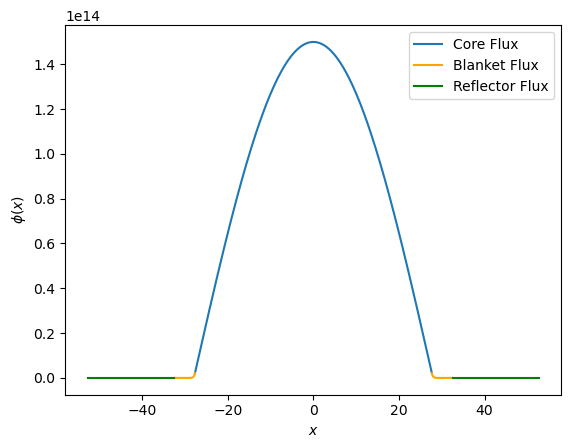

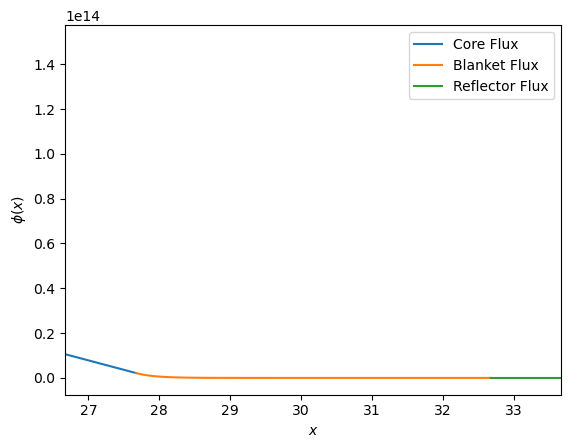

In [251]:

################################################################################
# Plotting
################################################################################
# Space
x_1 = np.linspace(Core_1.Start, Core_1.End, 100)
x_2 = np.linspace(Blanket_1.Start, Blanket_1.End, 100)
x_3 = np.linspace(Reflector_1.Start, Reflector_1.Start+20, 100) 

# Evaluation
phi1_vals = [phi1.subs(x, val).evalf() for val in x_1]
phi2_vals = [phi2.subs(x, val).evalf() for val in x_2]
phi3_vals = [phi3.subs(x, val).evalf() for val in x_3]

# Create symmetric values for x_1 and phi1_vals
x_1 = np.concatenate((-x_1[::-1], x_1))
phi1_vals = np.concatenate((phi1_vals[::-1], phi1_vals))

# Create symmetric values for x_2 and phi2_vals
x_2_sx = -x_2[::-1]
phi2_vals_sx = phi2_vals[::-1]

# Create symmetric values for x_3 and phi3_vals
x_3_sx = -x_3[::-1]
phi3_vals_sx = phi3_vals[::-1]

# Figure 1: Overall
plt.figure(1)
plt.plot(x_1, phi1_vals, label='Core Flux')
plt.plot(x_2, phi2_vals, label='Blanket Flux', color='orange')
plt.plot(x_2_sx, phi2_vals_sx, color='orange')
plt.plot(x_3, phi3_vals, label='Reflector Flux', color='green')
plt.plot(x_3_sx, phi3_vals_sx, color='green')
plt.xlabel('$x$')
plt.ylabel('$\phi(x)$')
plt.legend()
plt.show()

# Figure 2: Focus on the blanket
plt.figure(2)
plt.plot(x_1, phi1_vals, label='Core Flux')
plt.plot(x_2, phi2_vals, label='Blanket Flux')
plt.plot(x_3, phi3_vals, label='Reflector Flux')
plt.xlim(Blanket_1.Start -1, Blanket_1.End +1)
plt.xlabel('$x$')
plt.ylabel('$\phi(x)$')
plt.legend()
plt.show()
